# ==========================================
# 1. Imports e Configura√ß√µes
# ==========================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Locale para formato brasileiro
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil.1252')
    except:
        pass


# ==========================================
# 2. Leitura do Dataset
# ==========================================

Aqui carrego o dataset j√° limpo e preparado na etapa anterior de EDA.  
Mostro o shape e as primeiras linhas s√≥ para conferir se est√° tudo certo.

In [ ]:
df = pd.read_csv('export/dataset_preparado_para_modelo.csv')
print(f"Shape do dataset: {df.shape}")
display(df.head())

Shape do dataset: (30000, 31)


id  limite_credito       sexo  escolaridade casamento  idade  atraso_0  \
0   1         20000.0   Feminino  Universidade    Casado     24         2   
1   2        120000.0   Feminino  Universidade  Solteiro     26        -1   
2   3         90000.0   Feminino  Universidade  Solteiro     34         0   
3   4         50000.0   Feminino  Universidade    Casado     37         0   
4   5         50000.0  Masculino  Universidade    Casado     57        -1   

   atraso_2  atraso_3  atraso_4  ...  pagto_mes4  pagto_mes5  pagto_mes6  \
0         2        -1        -1  ...         0.0         0.0         0.0   
1         2         0         0  ...      1000.0         0.0      2000.0   
2         0         0         0  ...      1000.0      1000.0      5000.0   
3         0         0         0  ...      1100.0      1069.0      1000.0   
4         0        -1         0  ...      9000.0       689.0       679.0   

   inadimplente  proporcao_pago_1  proporcao_pago_2  proporcao_pago_3  \
0           Sim          0.000000          0.222043          0.000000   
1           Sim          0.000000          0.579374          0.372717   
2           N√£o          0.051915          0.106929          0.073746   
3           N√£o          0.042561          0.041858          0.024345   
4           N√£o          0.232072          6.468171          0.279049   

   proporcao_pago_4  proporcao_pago_5  proporcao_pago_6  
0          0.000000          0.000000          0.000000  
1          0.305530          0.000000          0.613121  
2          0.069774          0.066894          0.321543  
3          0.038849          0.036913          0.033843  
4          0.429779          0.035985          0.035490  

[5 rows x 31 columns]

# ==========================================
# 3. Separa√ß√£o em X e y, Treino/Teste
# ==========================================

Aqui, Separo as features (X) e o target (y), removo o ID, e divido em treino e teste mantendo o balanceamento das classes. Isso evita vazamento e garante avalia√ß√£o justa do modelo.

In [ ]:

X = df.drop(['inadimplente', 'id'], axis=1)
y = df['inadimplente']

# Bin√°rio para modelagem
y_bin = (y == "Sim").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.30, random_state=42, stratify=y_bin
)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (21000, 29), Teste: (9000, 29)


# ==========================================
# 4. Identifica√ß√£o de Colunas
# ==========================================

Detecto automaticamente quais colunas s√£o num√©ricas e quais s√£o categ√≥ricas.  
Assim posso aplicar o tratamento adequado para cada tipo no pipeline.

In [ ]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
print("Num√©ricas:", num_cols)
print("Categ√≥ricas:", cat_cols)

Num√©ricas: ['limite_credito', 'idade', 'atraso_0', 'atraso_2', 'atraso_3', 'atraso_4', 'atraso_5', 'atraso_6', 'fatura_mes1', 'fatura_mes2', 'fatura_mes3', 'fatura_mes4', 'fatura_mes5', 'fatura_mes6', 'pagto_mes1', 'pagto_mes2', 'pagto_mes3', 'pagto_mes4', 'pagto_mes5', 'pagto_mes6', 'proporcao_pago_1', 'proporcao_pago_2', 'proporcao_pago_3', 'proporcao_pago_4', 'proporcao_pago_5', 'proporcao_pago_6']
Categ√≥ricas: ['sexo', 'escolaridade', 'casamento']


# ==========================================
# 5. Pipeline de Pr√©-processamento
# ==========================================

## Monto o pipeline:  
- Dados num√©ricos t√™m os nulos preenchidos pela m√©dia e s√£o padronizados.  
- Dados categ√≥ricos t√™m os nulos preenchidos com o valor mais comum e s√£o convertidos em dummies (OneHotEncoder).  
Deixo tudo pronto para rodar qualquer modelo sem risco de erro de dado faltando.


In [ ]:

from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


# ==========================================
# 6. Modelos para Treinamento
# ==========================================

## Testo v√°rios modelos (Log√≠stica, √Årvore, Random Forest, XGBoost e LightGBM).  
Para cada um, salvo as principais m√©tricas, matriz de confus√£o e probabilidades para an√°lise posterior.  
Assim vejo de forma r√°pida qual modelo performa melhor na base.


In [ ]:
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "√Årvore de Decis√£o": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=120, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

resultados = []

for nome, modelo in modelos.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', modelo)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    # M√©tricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Matriz de confus√£o detalhada
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    resultados.append({
        "Modelo": nome,
        "Acur√°cia (%)": 100*acc,
        "Precis√£o (%)": 100*prec,
        "Revoca√ß√£o (Recall) (%)": 100*rec,
        "F1-Score (%)": 100*f1,
        "AUC": auc,
        "Verdadeiro Negativo": tn,
        "Falso Positivo": fp,
        "Falso Negativo": fn,
        "Verdadeiro Positivo": tp,
        "y_proba": y_proba,  
        "y_pred": y_pred
    })


[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4800
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,221190 -> initscore=-1,258742
[LightGBM] [Info] Start training from score -1,258742


# ==========================================
# 7. Tabela de Resultados
# ==========================================

Fa√ßo um resumo com os principais resultados (acur√°cia, precis√£o, recall, F1, AUC e detalhes da matriz de confus√£o) j√° formatados para apresenta√ß√£o ou exporta√ß√£o.


In [ ]:
tabela_result = pd.DataFrame(resultados).drop(['y_proba','y_pred'], axis=1)
cols_fmt = [
    "Acur√°cia (%)", "Precis√£o (%)", "Revoca√ß√£o (Recall) (%)", "F1-Score (%)",
    "Verdadeiro Negativo", "Falso Positivo", "Falso Negativo", "Verdadeiro Positivo"
]
for col in cols_fmt:
    tabela_result[col] = tabela_result[col].map(lambda x: locale.format_string('%.2f', x, grouping=True) if " (%)" in col else locale.format_string('%d', x, grouping=True))
tabela_result['AUC'] = tabela_result['AUC'].map(lambda x: locale.format_string('%.3f', x) if not pd.isnull(x) else '---')
display(tabela_result)


Modelo Acur√°cia (%) Precis√£o (%) Revoca√ß√£o (Recall) (%)  \
0  Regress√£o Log√≠stica        80,91        69,87                  24,11   
1    √Årvore de Decis√£o        72,36        38,40                  41,34   
2        Random Forest        81,60        64,86                  36,72   
3              XGBoost        81,64        64,70                  37,47   
4             LightGBM        81,83        66,51                  36,01   

  F1-Score (%)    AUC Verdadeiro Negativo Falso Positivo Falso Negativo  \
0        35,85  0,716               6.802            207          1.511   
1        39,82  0,613               5.689          1.320          1.168   
2        46,89  0,755               6.613            396          1.260   
3        47,46  0,757               6.602            407          1.245   
4        46,73  0,776               6.648            361          1.274   

  Verdadeiro Positivo  
0                 480  
1                 823  
2                 731  
3                 746  
4                 717

# ==========================================
# 8. Visualiza√ß√£o das Matrizes de Confus√£o e Curvas ROC
# ==========================================

Exibo a matriz de confus√£o e a curva ROC de cada modelo para visualizar onde acertou/errou e como est√° discriminando entre adimplentes e inadimplentes.

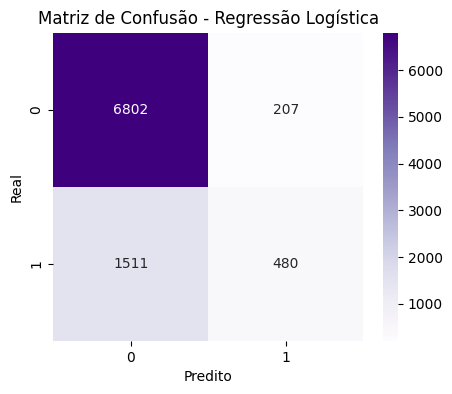

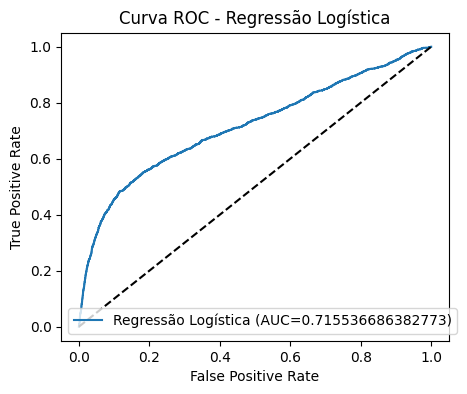

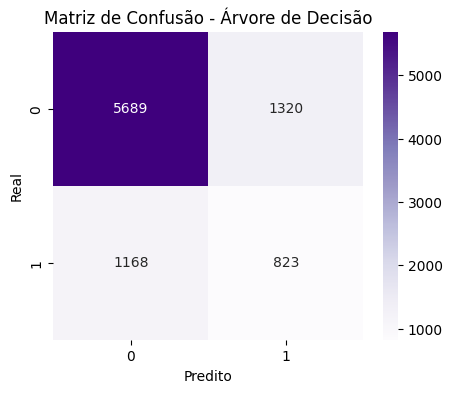

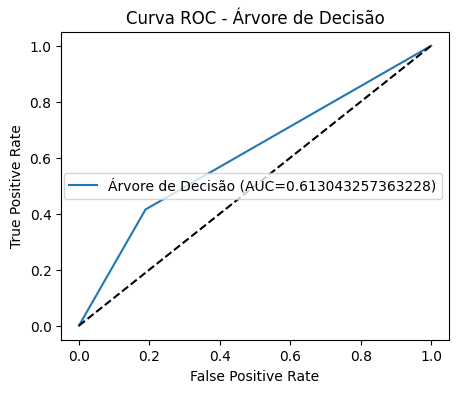

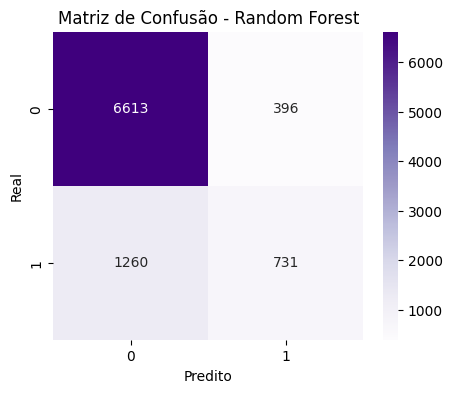

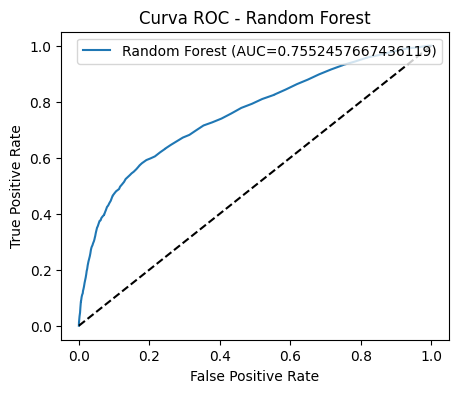

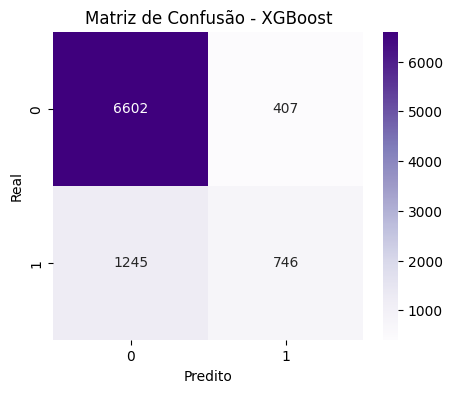

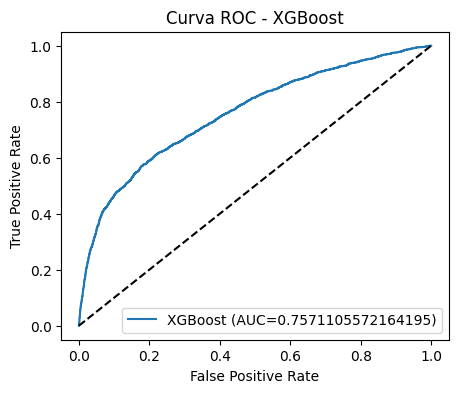

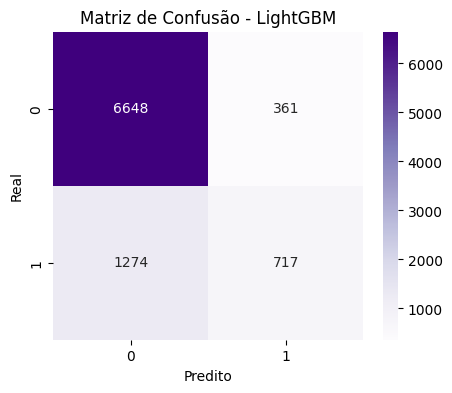

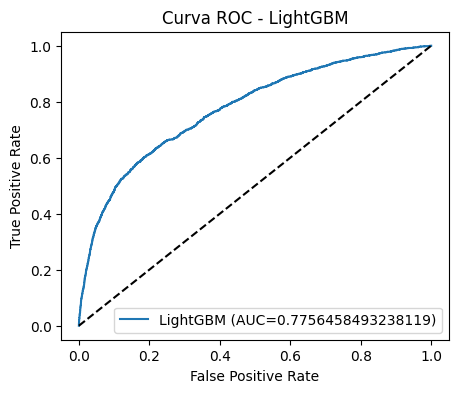

In [ ]:
for i, row in enumerate(resultados):
    nome = row['Modelo']
    cmatrix = np.array([[int(row['Verdadeiro Negativo']), int(row['Falso Positivo'])],
                        [int(row['Falso Negativo']), int(row['Verdadeiro Positivo'])]])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Purples')
    plt.title(f"Matriz de Confus√£o - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    y_proba = resultados[i]['y_proba']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = resultados[i]['AUC']
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"{nome} (AUC={auc})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nome}")
        plt.legend()
        plt.show()


# ==========================================
# 9. Resumo Executivo dos Resultados dos Modelos
# ==========================================

üîé **Resumo Executivo**

O modelo com melhor performance para prever inadimpl√™ncia foi o **LightGBM**.
A m√©trica AUC (√Årea sob a Curva ROC), que indica o poder de discrimina√ß√£o entre inadimplentes e n√£o inadimplentes, foi de **0,776** para este modelo.

üìä **Ranking dos Modelos Avaliados:**



üí° **Interpreta√ß√£o r√°pida:**
- O LightGBM apresentou o maior AUC, indicando melhor performance para classifica√ß√£o.
- Os modelos de ensemble (Random Forest, XGBoost, LightGBM) superaram os modelos mais simples (Regress√£o Log√≠stica e √Årvore de Decis√£o) neste caso.
- A m√©trica AUC √© a principal refer√™ncia em problemas de cr√©dito, pois mostra o qu√£o bem o modelo diferencia perfis de risco.


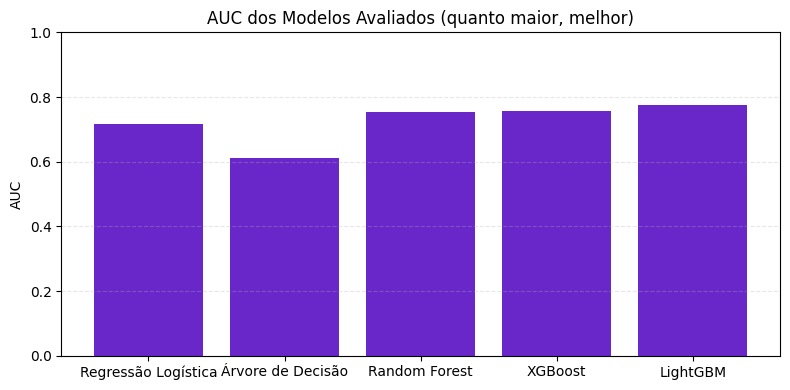

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cria tabela a partir da lista de resultados (se ainda n√£o existir)
tabela_result = pd.DataFrame(resultados).drop(['y_proba','y_pred'], axis=1)

# Formata colunas para portugu√™s/brasileiro
import locale
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil.1252')
    except:
        pass

cols_fmt = [
    "Acur√°cia (%)", "Precis√£o (%)", "Revoca√ß√£o (Recall) (%)", "F1-Score (%)",
    "Verdadeiro Negativo", "Falso Positivo", "Falso Negativo", "Verdadeiro Positivo"
]
for col in cols_fmt:
    tabela_result[col] = tabela_result[col].map(
        lambda x: locale.format_string('%.2f', x, grouping=True) if " (%)" in col else locale.format_string('%d', x, grouping=True)
    )
tabela_result['AUC'] = tabela_result['AUC'].map(
    lambda x: locale.format_string('%.3f', x) if not pd.isnull(x) else '---'
)

# Identifica melhor modelo (maior AUC)
tabela_result['AUC_float'] = pd.to_numeric(tabela_result['AUC'].str.replace(',','.'), errors='coerce')
melhor_idx = tabela_result['AUC_float'].idxmax()
melhor_modelo = tabela_result.loc[melhor_idx, 'Modelo']
melhor_auc = tabela_result.loc[melhor_idx, 'AUC']

print(f"üîé **Resumo Executivo**")
print(f"\nO modelo com melhor performance para prever inadimpl√™ncia foi o **{melhor_modelo}**.")
print(f"A m√©trica AUC (√Årea sob a Curva ROC), que indica o poder de discrimina√ß√£o entre inadimplentes e n√£o inadimplentes, foi de **{melhor_auc}** para este modelo.\n")

print("üìä **Ranking dos Modelos Avaliados:**")
display(tabela_result.drop(columns='AUC_float').reset_index(drop=True).style
    .highlight_max(subset=['AUC'], color='#c3f7b7')
    .set_caption('Compara√ß√£o de Modelos - Quanto maior o AUC, melhor o modelo')
)

print("\nüí° **Interpreta√ß√£o r√°pida:**")
print(f"- O {melhor_modelo} apresentou o maior AUC, indicando melhor performance para classifica√ß√£o.")
print("- Os modelos de ensemble (Random Forest, XGBoost, LightGBM) superaram os modelos mais simples (Regress√£o Log√≠stica e √Årvore de Decis√£o) neste caso.")
print("- A m√©trica AUC √© a principal refer√™ncia em problemas de cr√©dito, pois mostra o qu√£o bem o modelo diferencia perfis de risco.")

# Ranking visual em barra
plt.figure(figsize=(8,4))
plt.bar(tabela_result['Modelo'], tabela_result['AUC_float'], color="#6927c9")
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.title("AUC dos Modelos Avaliados (quanto maior, melhor)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# ===============================================
# Bloco Final - Salvando Resultados e Melhor Modelo
# ===============================================

In [ ]:
import pandas as pd
import numpy as np
from joblib import dump

# 1. Salva a tabela de resultados dos modelos
df_result = pd.DataFrame(resultados).drop(['y_proba', 'y_pred'], axis=1)
df_result.to_csv('export/modelos_resultados.csv', index=False)
print("‚úÖ Arquivo 'export/modelos_resultados.csv' exportado com sucesso!")

# 2. Salva arrays de predi√ß√µes de TODOS os modelos
for row in resultados:
    nome = row['Modelo']
    pd.DataFrame({
        'y_true': np.array(y_test),  
        'y_pred': np.array(row['y_pred']),
        'y_proba': np.array(row['y_proba']) if row['y_proba'] is not None else [None]*len(y_test)
    }).to_csv(f"export/predicoes_{nome.replace('√ß','c').replace('√£','a').replace('√°','a').replace('√≠','i').replace('√©','e').replace('√≥','o').replace('√∫','u').replace('√¥','o').replace('√™','e').replace('√¥','o').replace(' ','_').replace('-','').replace('__','_').lower()}.csv", index=False)

print("‚úÖ Predi√ß√µes de teste de cada modelo exportadas.")

# 3. Salva o pipeline do melhor modelo (com maior AUC)
df_result['AUC'] = pd.to_numeric(df_result['AUC'], errors='coerce')
melhor_idx = df_result['AUC'].idxmax()
melhor_nome = df_result.loc[melhor_idx, 'Modelo']
print(f"‚≠ê Melhor modelo encontrado: {melhor_nome}")

melhor_modelo = modelos[melhor_nome]
melhor_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', melhor_modelo)
])
melhor_pipe.fit(X_train, y_train)
dump(melhor_pipe, 'export/melhor_modelo.joblib')
print("‚úÖ Pipeline do melhor modelo salvo em 'export/melhor_modelo.joblib'.")

# 4. Salva dataset de teste com predi√ß√µes do melhor modelo
melhor_pred = melhor_pipe.predict(X_test)
melhor_proba = melhor_pipe.predict_proba(X_test)[:, 1]
df_teste = X_test.copy()
df_teste['inadimplente_real'] = y_test.values
df_teste['inadimplente_pred'] = melhor_pred
df_teste['inadimplente_proba'] = melhor_proba
df_teste.to_csv('export/teste_com_predicoes.csv', index=False)
print("‚úÖ Base de teste com predi√ß√µes salva em 'export/teste_com_predicoes.csv'.")

print("\nTodos os arquivos para o notebook 03 e Power BI foram gerados! üöÄ")



‚úÖ Arquivo 'export/modelos_resultados.csv' exportado com sucesso!
‚úÖ Predi√ß√µes de teste de cada modelo exportadas.
‚≠ê Melhor modelo encontrado: LightGBM
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4800
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,221190 -> initscore=-1,258742
[LightGBM] [Info] Start training from score -1,258742
‚úÖ Pipeline do melhor modelo salvo em 'export/melhor_modelo.joblib'.
‚úÖ Base de teste com predi√ß√µes salva em 'export/teste_com_predicoes.csv'.

Todos os arquivos para o notebook 03 e Power BI foram gerados! üöÄ
